In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

import torch
from torch.utils.data import TensorDataset, DataLoader
from src.model_specpred_dropout import DropoutSpectrumPredictor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1/5, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [8]:
model_spec = DropoutSpectrumPredictor(num_param_in=X.shape[1], num_mode=2, dropout_rate=0.1)
print(model_spec)

DropoutSpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=64, out_features=4, bias=False)
  )
)


In [9]:
trainer = pl.Trainer(
    max_epochs=10000, accelerator="gpu",
    callbacks=[TQDMProgressBar(refresh_rate=5)],
    log_every_n_steps=2, devices=1, 
    enable_checkpointing=True,
    default_root_dir="training_logs"
    )

trainer.fit(model_spec, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | fc_net | Sequential | 42.2 K
--------------------------------------
42.2 K    Trainable params
0         Non-trainable params
42.2 K    Total params
0.169     Total estimated model params size (MB)
c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1670:  80%|████████  | 20/25 [00:00<00:00, 153.08it/s, loss=0.541, v_num=51]

c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [6]:
# model_spec.load_from_checkpoint("training_logs/lightning_logs/version_0/checkpoints/epoch=9999-step=210000.ckpt")

SpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=4, bias=False)
  )
)

In [12]:
model_spec.eval()
Y_val_pred = []
with torch.no_grad():
    for x_val in X_val:
        Y_val_pred.append(model_spec(x_val.to(model_spec.device)).detach())
Y_val_pred = torch.vstack(Y_val_pred).cpu()

Epoch 159:  80%|████████  | 20/25 [06:27<01:36, 19.39s/it, loss=0.732, v_num=50] 


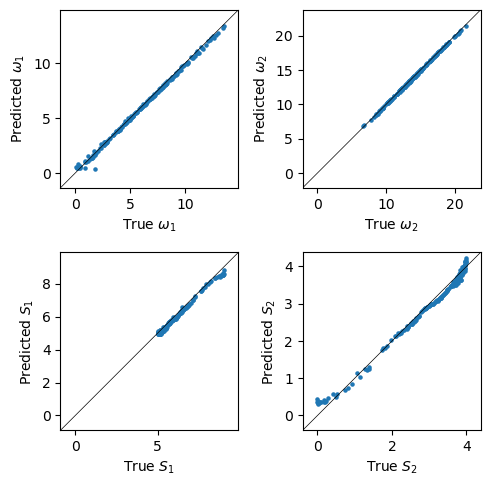

In [13]:
labels = ['$\omega_1$', '$\omega_2$', '$S_1$', '$S_2$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5)
    ax.scatter(Y_val[:,i], Y_val_pred[:,i], s=5)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_ylim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}")
    ax.set_ylabel(f"Predicted {labels[i]}")

fig.tight_layout()

In [43]:
import numpy as np
val_idx = np.random.choice(len(X_val))
x_val = X_val[val_idx].to(model_spec.device)

In [44]:
model_spec.train()
y_val_mc = []
with torch.no_grad():
    for i in range(1000):
        y_val_mc.append(model_spec(x_val).detach().cpu().numpy())

In [45]:
y_val_mc = np.vstack(y_val_mc)

In [47]:
fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(2,2)

<Figure size 500x500 with 0 Axes>

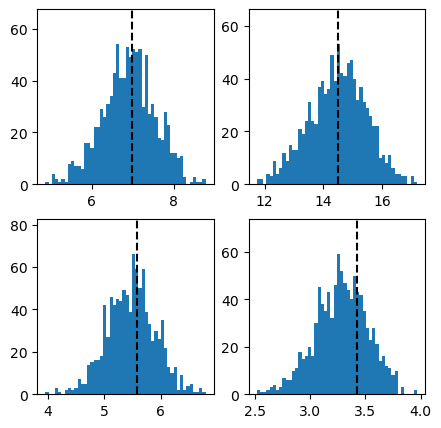

In [52]:
fig = plt.figure(figsize=(5,5))
gs = fig.add_gridspec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    nums, _, _ = ax.hist(y_val_mc[:,i], bins=50)
    ax.vlines(Y_val[val_idx,i], 0, 1e3, color='k', linestyle='--')
    ax.set_ylim([0, nums.max()*1.25])